In [3]:

import matplotlib.pyplot as plt
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from autograd import grad, elementwise_grad


def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    return sigmoid(z) * (1-sigmoid(z))

def mse(predict, target):
    return np.mean((predict - target) ** 2)

def mse_der(predict, target):
    return 2*(predict - target)/ len(predict)


def runge(x):
    return 1/(1+25*x**2)


In [4]:
def create_layers(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        b = np.random.randn(layer_output_size)
        layers.append((W, b))

        i_size = layer_output_size
    return layers

def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = W @ a + b
        a = activation_func(z)
    return a

def cost(input,layers, activation_funcs, target):
    predict = feed_forward(input, layers, activation_funcs)
    return mse(predict, target)


def feed_forward_saver(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = W @ a + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

def backpropagation(
    input, layers, activation_funcs, activation_ders, target, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = W.T @ dC_dz

        dC_dz = dC_da * activation_der(z)
        dC_dW = np.outer(dC_dz, layer_input)
        dC_db = dC_dz

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads



In [5]:
#Standard GD (Original)
def train_network(input, layers, activation_funcs, activation_ders, target, learning_rate, epochs):
    accuracies = []
    predictions = []
    for i in range(epochs):
        layers_grad = backpropagation(input, layers, activation_funcs, activation_ders, target)
        for (W, b), (W_g, b_g) in zip(layers, layers_grad):
            
            W -= learning_rate * W_g
            b -= learning_rate * b_g

        accuracies.append(cost(input,layers, activation_funcs, target))
        predictions.append(feed_forward(input, layers, activation_funcs))
    return layers, accuracies, predictions

#Standard GD (RMS)
def train_network_gd_rmsprop(input, layers, activation_funcs, activation_ders, target, learning_rate, epochs, beta=0.9, epsilon=1e-8):
    accuracies = []
    predictions = []
    for _ in range(epochs):
        # Compute gradients for the entire dataset
        layers_grad = backpropagation(input, layers, activation_funcs, activation_ders, target)
        # Initialize cache for RMSProp (mean square gradients)
        cache = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
        
        for i, ((W, b), (W_g, b_g)) in enumerate(zip(layers, layers_grad)):
            # Update cache with moving average of squared gradients
            cache[i] = (
                beta * cache[i][0] + (1 - beta) * np.square(W_g),
                beta * cache[i][1] + (1 - beta) * np.square(b_g)
            )
            # Update weights and biases using RMSProp
            W -= learning_rate * W_g / (np.sqrt(cache[i][0]) + epsilon)
            b -= learning_rate * b_g / (np.sqrt(cache[i][1]) + epsilon)
            layers[i] = (W, b)

            accuracies.append(cost(input,layers, activation_funcs, target))
            predictions.append(feed_forward(input, layers, activation_funcs))
    
    return layers, accuracies, predictions


# Standard GD (Adam)
def train_network_gd_adam(input_data, layers, activation_funcs, activation_ders, target, learning_rate, epochs, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for _ in range(epochs):
        # Compute gradients for the entire dataset
        layers_grad = backpropagation(input_data, layers, activation_funcs, activation_ders, target)
        # Initialize first and second moment caches
        m = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]  # First moment (mean)
        v = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]  # Second moment (uncentered variance)
        
        for i, ((W, b), (W_g, b_g)) in enumerate(zip(layers, layers_grad)):
            # Update first moment (moving average of gradients)
            m[i] = (
                beta1 * m[i][0] + (1 - beta1) * W_g,
                beta1 * m[i][1] + (1 - beta1) * b_g
            )
            # Update second moment (moving average of squared gradients)
            v[i] = (
                beta2 * v[i][0] + (1 - beta2) * np.square(W_g),
                beta2 * v[i][1] + (1 - beta2) * np.square(b_g)
            )
            # Bias correction for first and second moments
            m_hat_w, m_hat_b = m[i][0] / (1 - beta1), m[i][1] / (1 - beta1)
            v_hat_w, v_hat_b = v[i][0] / (1 - beta2), v[i][1] / (1 - beta2)
            # Update weights and biases using Adam
            W -= learning_rate * m_hat_w / (np.sqrt(v_hat_w) + epsilon)
            b -= learning_rate * m_hat_b / (np.sqrt(v_hat_b) + epsilon)
            layers[i] = (W, b)
    
    return layers

#Stochastic GD (RMS)

#Stochastic GD (ADAM)

Final MSE = 0.41892164729950115


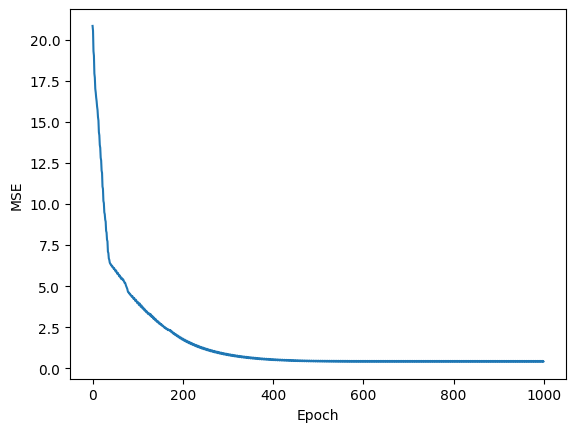

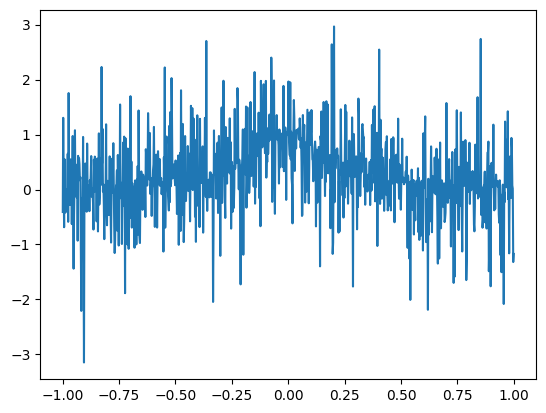

In [6]:
#Define target and other parameters

def runge(x):
    return 1/(1+25*x**2)

network_input_size = 1000
x = np.linspace(-1,1,network_input_size)
y = runge(x) + 0.05*np.random.normal(0,1,network_input_size)
input = x
target = y

layer_output_sizes = [50, 1000]
activation_funcs = [sigmoid, lambda x: x]  # Sigmoid for hidden, linear for output
activation_ders = [sigmoid_der, lambda x: np.ones_like(x)]  # Sigmoid derivative, linear derivative
layers = create_layers(network_input_size, layer_output_sizes)

learning_rate = 0.0006     #0.30 works best for normal GD
epochs = 500

#Plot
"""
acc = train_network(input, layers, activation_funcs, activation_ders, target, learning_rate, epochs)[1]
pred = train_network(input, layers, activation_funcs, activation_ders, target, learning_rate, epochs)[2]
"""
acc = train_network_gd_rmsprop(input, layers, activation_funcs, activation_ders, target, learning_rate, epochs, beta=0.9, epsilon=1e-8)[1]
pred = train_network_gd_rmsprop(input, layers, activation_funcs, activation_ders, target, learning_rate, epochs, beta=0.9, epsilon=1e-8)[2]
print(f"Final MSE = {acc[-1]}")
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

#NESTE MÅL ER Å FIKSE STOCHASTIC GD SLIK AT DEN TAR INN BATCHES PÅ (INPUT_SIZE/10) OM GANGEN

"""
print("Sample predictions vs targets:")
for i in range(0,epochs,11):
    print(f"x={x[i]:.4f}, pred={predictions[-1][i]:.4f}, target={y[i]:.4f}")
"""
plt.plot(input,pred[-1])


In [7]:
from autograd import grad


lay =backpropagation(
    input, layers, activation_funcs, activation_ders, target, cost_der=mse_der)
print(lay[-1][0][0])

grad_cost_wrt_layers = grad(cost, argnum=1)
auto_grads = grad_cost_wrt_layers(x, layers, activation_funcs, target)
print(auto_grads[-1][0][0])

diff = 0
for i in range(len(lay)):
    diff += (abs(lay[-1][0][0][i])-abs(auto_grads[-1][0][0][i]))
if diff <= 10**-6:
    print("Same gradients") 

[-7.93537979e-18 -2.41075699e-04 -8.07385242e-17 -7.53920179e-05
 -1.26256191e-04 -7.33189071e-04 -9.39117107e-05 -7.23630098e-12
 -2.42614068e-04 -7.33189071e-04 -1.90680036e-04 -1.95975675e-04
 -7.33189071e-04 -7.33189071e-04 -6.32005774e-13 -7.88134794e-14
 -3.49103936e-04 -1.99199251e-04 -1.34522286e-04 -4.31215083e-04
 -2.78463906e-04 -1.98270658e-04 -1.60845887e-04 -9.88576136e-13
 -1.29998866e-04 -3.76456912e-15 -1.44378552e-04 -3.26271355e-04
 -1.53590582e-04 -2.32342901e-04 -1.35246249e-12 -1.23245343e-12
 -1.92956143e-04 -9.36930525e-05 -6.92810524e-05 -1.62365633e-04
 -2.41708792e-04 -1.95030104e-04 -2.50747769e-04 -2.63506373e-04
 -1.96050776e-04 -2.84824096e-04 -1.90539179e-13 -4.85001749e-05
 -1.28897242e-04 -3.50678650e-11 -2.52998030e-04 -1.64552026e-04
 -7.33189071e-04 -1.18511147e-04]
[-7.93537979e-18 -2.41075699e-04 -8.07385242e-17 -7.53920179e-05
 -1.26256191e-04 -7.33189071e-04 -9.39117107e-05 -7.23630098e-12
 -2.42614068e-04 -7.33189071e-04 -1.90680036e-04 -1.9597